### Get the data

In [102]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
plt.rcParams['figure.figsize'] = [20, 20]
import numpy as np
import scipy

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, 
                             precision_recall_curve, silhouette_samples, silhouette_score)
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import cross_val_predict, train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [2]:
X_orig, y_orig = fetch_olivetti_faces(return_X_y=True)

In [3]:
X_train, X_rest, y_train, y_rest = train_test_split(X_orig, y_orig, train_size=0.7, shuffle=True, stratify=y_orig)

In [4]:
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, train_size=0.5, shuffle=True, stratify=y_rest)

### Explore the data

In [18]:
ks = list(range(1, 200))

In [16]:
%%time

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_train)
                for k in ks]
inertias = [model.inertia_ for model in kmeans_per_k]

CPU times: user 1h 10min 16s, sys: 5min 7s, total: 1h 15min 23s
Wall time: 12min 54s


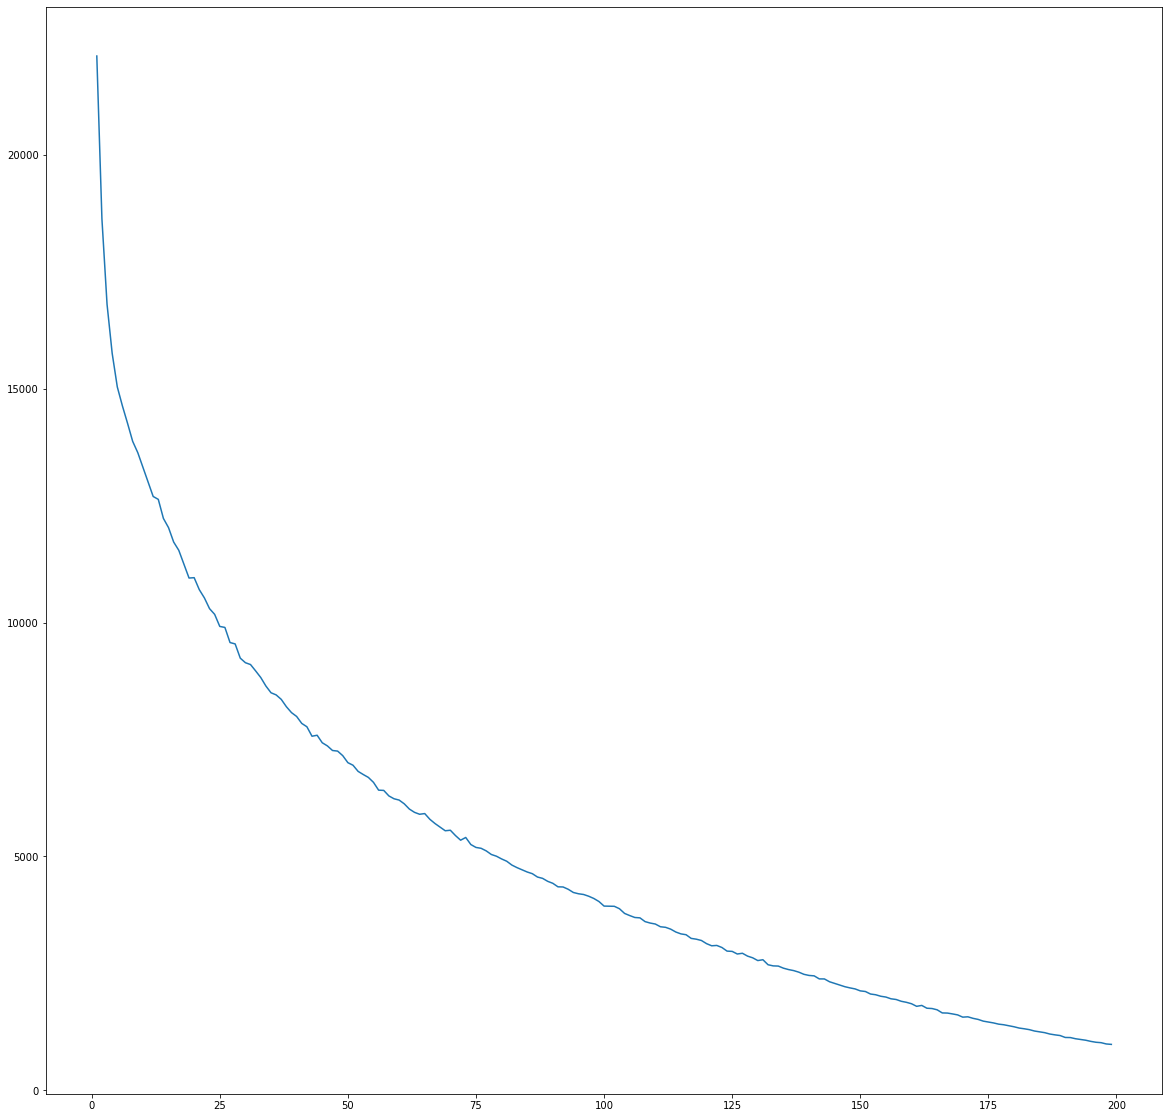

In [17]:
plt.plot(ks, inertias)

In [24]:
silhouette_scores = [silhouette_score(X_train, model.labels_)
                    for model in kmeans_per_k[1:]]

In [65]:
silhouette_scores[80:85]

[0.19210146, 0.19328316, 0.19911602, 0.18756577, 0.18985127]

In [34]:
np.argmax(np.array(silhouette_scores))

82

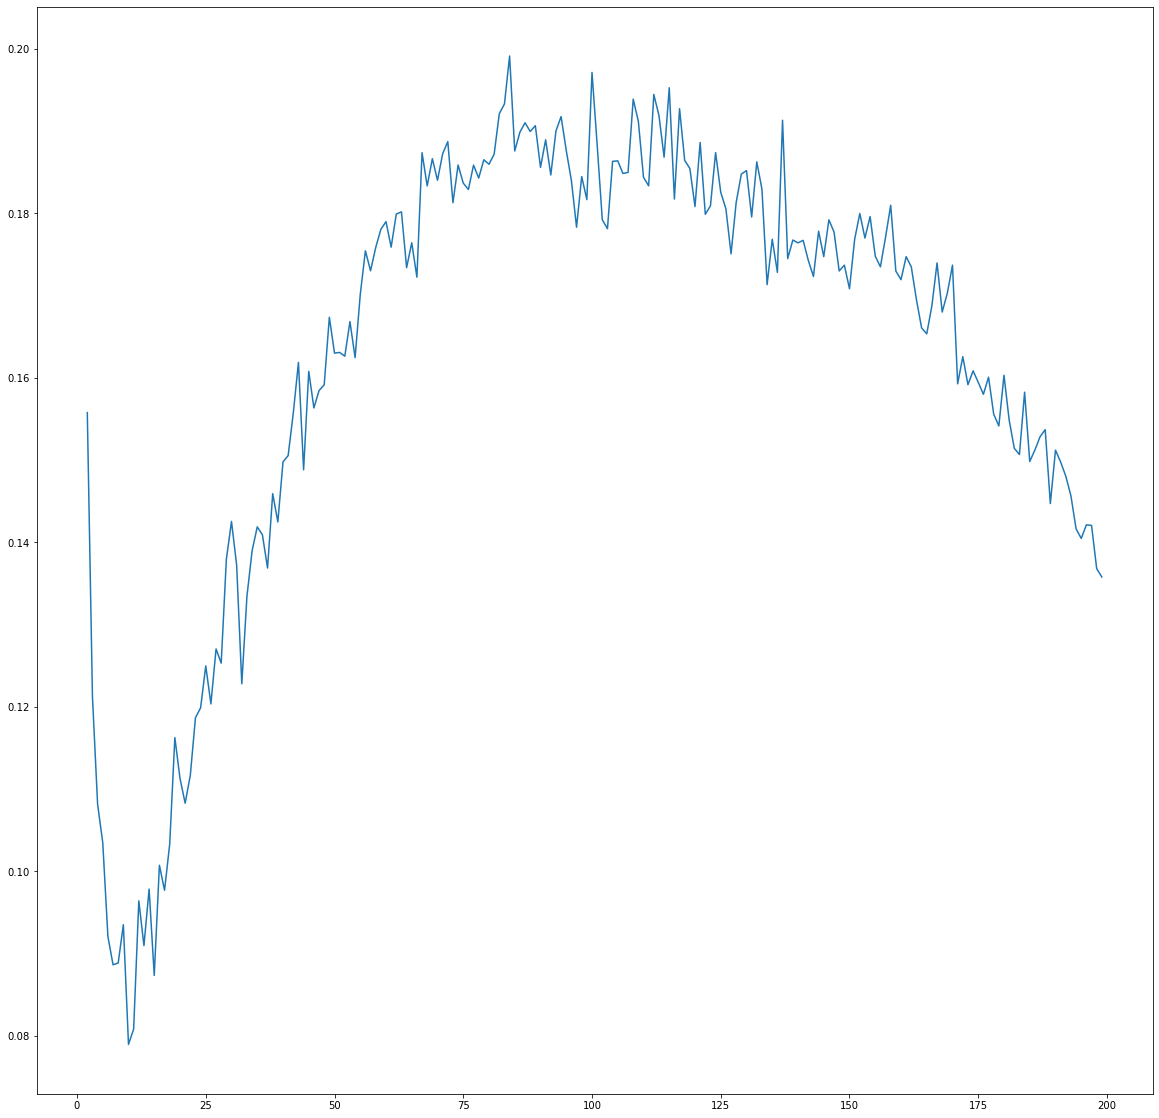

In [25]:
plt.plot(ks[1:], silhouette_scores)

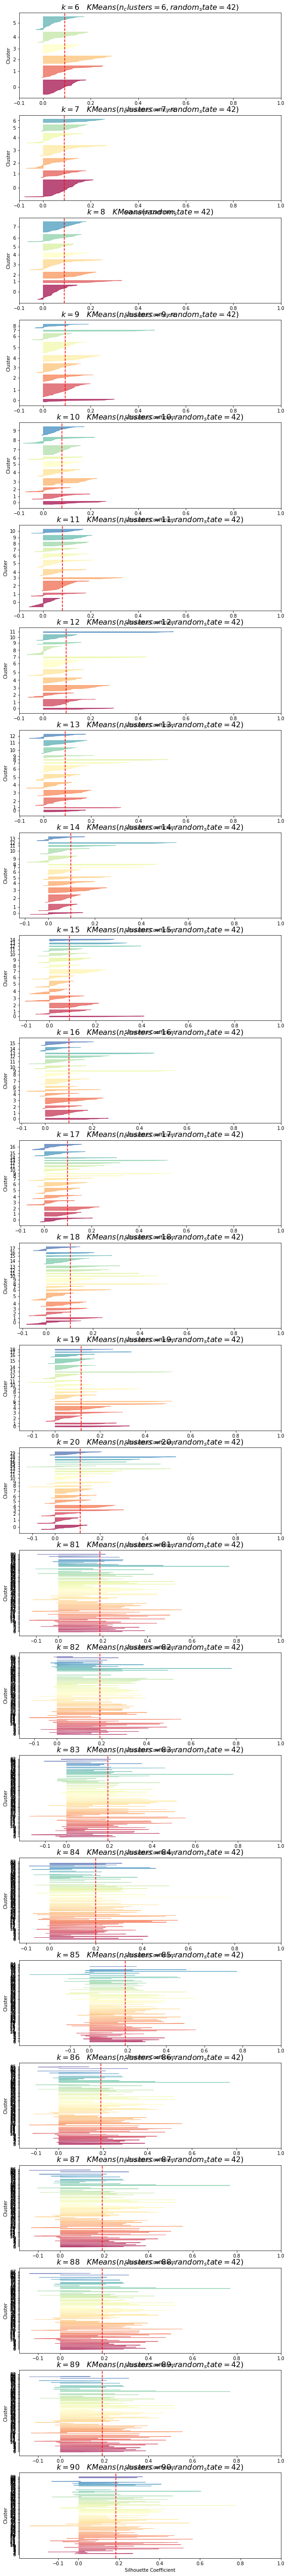

In [64]:
# adapted from https://github.com/ageron/handson-ml2/blob/master/09_unsupervised_learning.ipynb


plt.figure(figsize=(10, 100))
# offset = 75
# limit = 25
plot_ks = ks[5: 20] + ks[80:90]

for idx, k in enumerate(plot_ks):
    plt.subplot(len(plot_ks), 1, idx+1)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X_train, y_pred)

    padding = len(X_train) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    plt.ylabel("Cluster")
    plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.xlabel("Silhouette Coefficient")
    # else:
    #     plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={} \quad {}$".format(k, kmeans_per_k[k-1]), fontsize=16)

plt.show()

I'm having a hard time believing that 82 clusters is really a good choice given how a nontrivial number of clusters have negative silhouette coefficients, so let's spot check some clusters.

In [68]:
k_means_84 = kmeans_per_k[83]
k_means_84

KMeans(n_clusters=84, random_state=42)

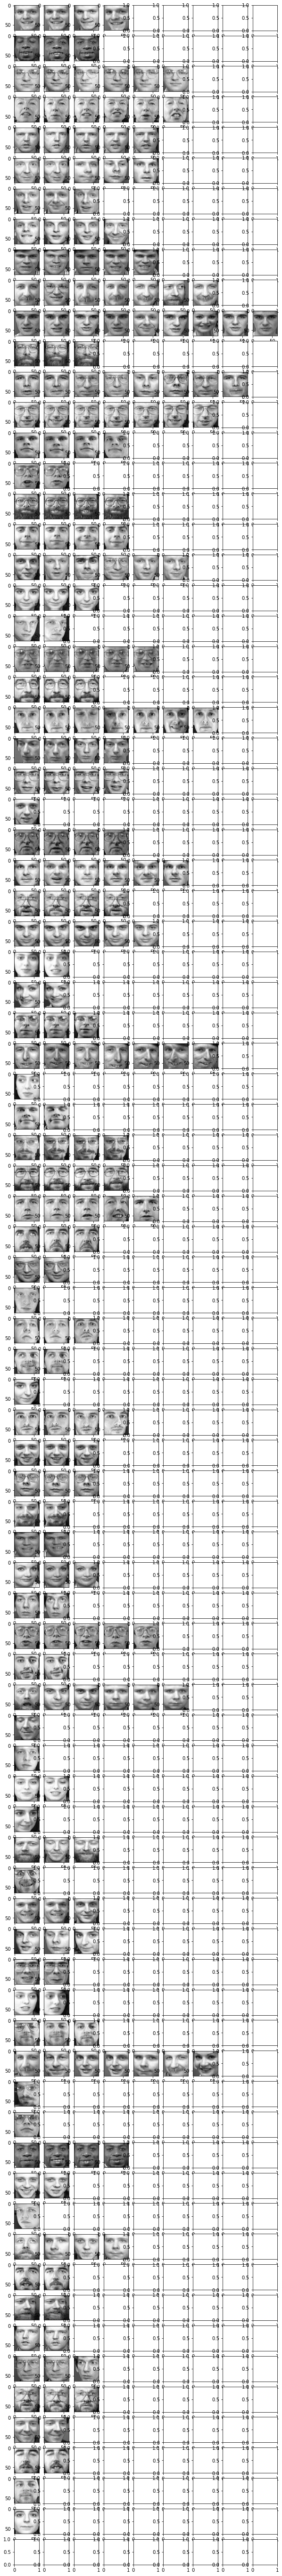

In [99]:
model = k_means_84
largest_cluster_size = np.bincount(model.labels_).max()
fig, ax = plt.subplots(model.n_clusters, largest_cluster_size, figsize=(10, 100))
for i in range(1, model.n_clusters+1):
    idx = model.labels_ == i
    cluster = X_train[idx]
    for j, img in enumerate(cluster):
        ax[i-1, j].imshow(img.reshape((64, 64)), cmap="gray")

On the other hand 6 clusters doesn't seem entirely unreasonable. This time I'll plot each cluster columnwise since the clusters will be much larger.

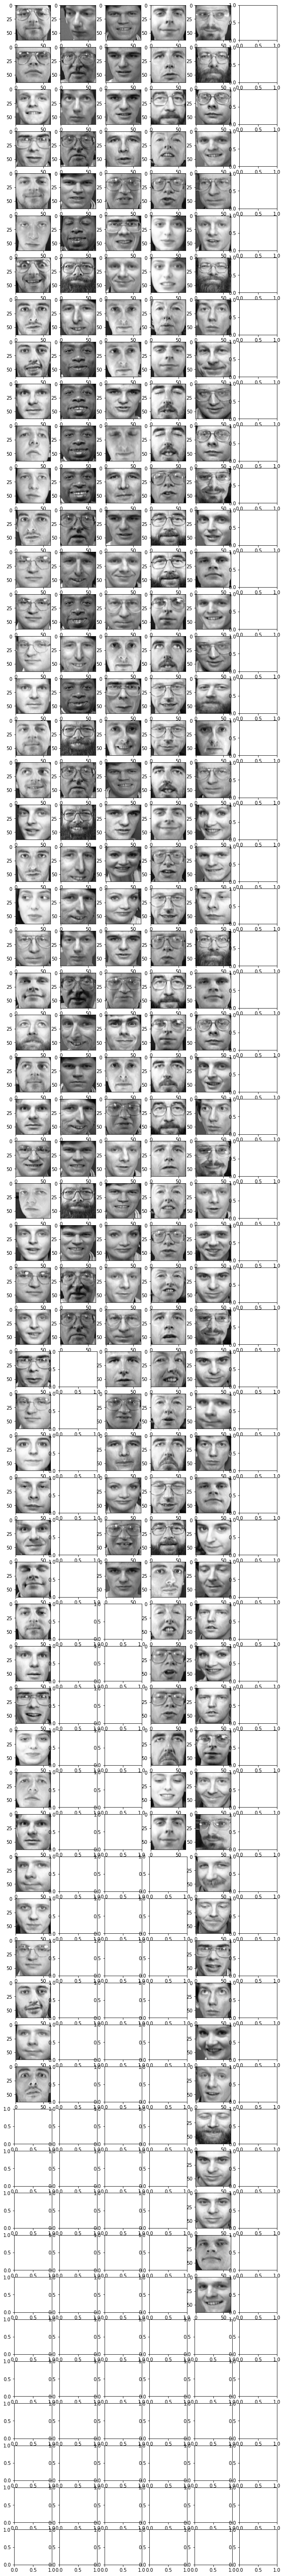

In [100]:
model = kmeans_per_k[5]
largest_cluster_size = np.bincount(model.labels_).max()
fig, ax = plt.subplots(largest_cluster_size, model.n_clusters, figsize=(10, 100))
for i in range(1, model.n_clusters+1):
    idx = model.labels_ == i
    cluster = X_train[idx]
    for j, img in enumerate(cluster):
        ax[j, i-1].imshow(img.reshape((64, 64)), cmap="gray")

Not very compelling. What about 40 clusters since there are 40 different people? Clusters are row-wise this time.

KMeans(n_clusters=40, random_state=42)


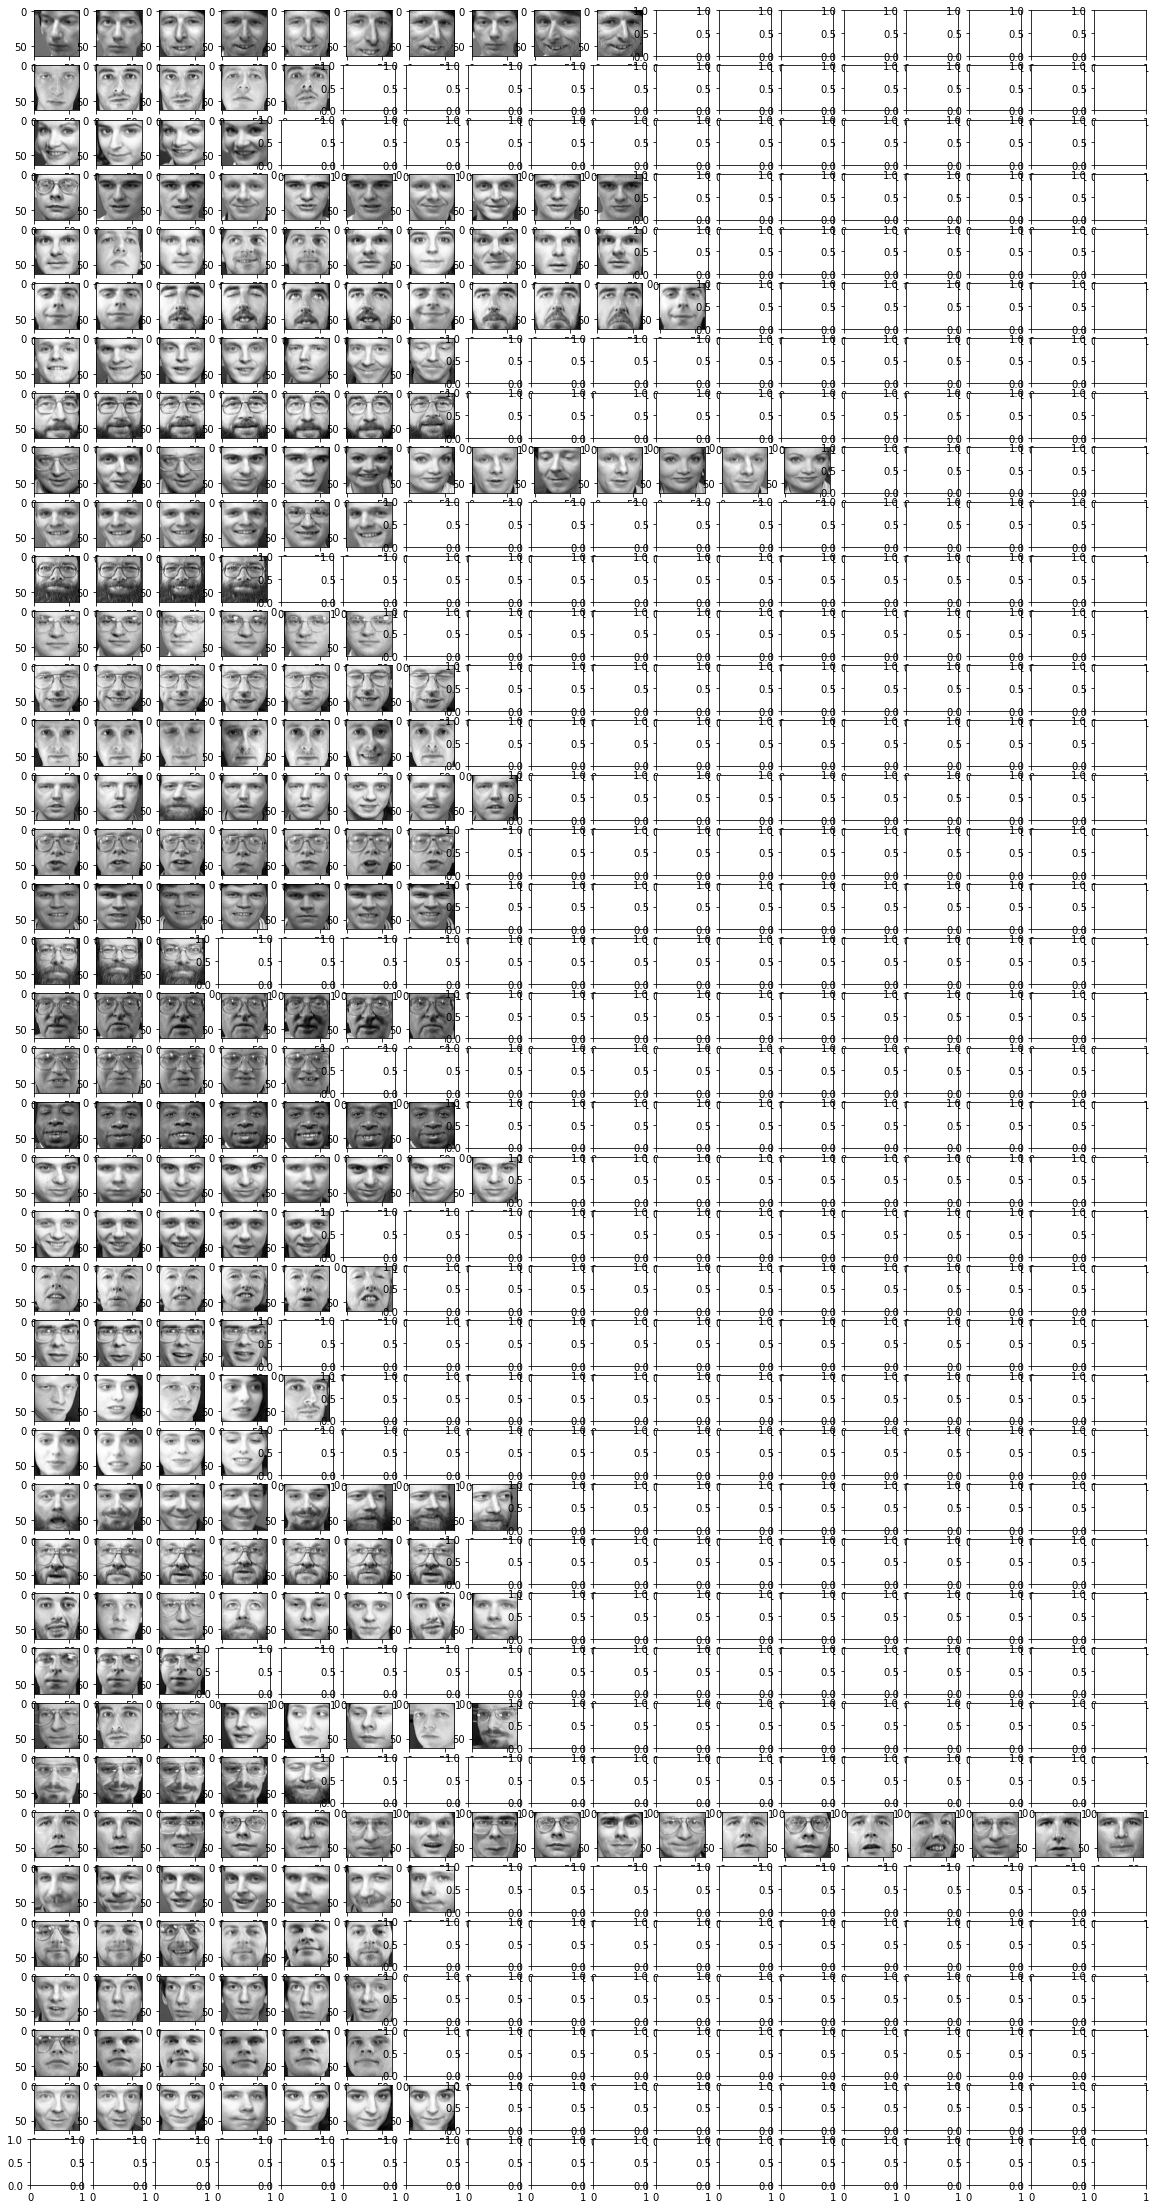

In [101]:
model = kmeans_per_k[39]
print(model)
largest_cluster_size = np.bincount(model.labels_).max()
fig, ax = plt.subplots(model.n_clusters, largest_cluster_size, figsize=(20, 40))
for i in range(1, model.n_clusters+1):
    idx = model.labels_ == i
    cluster = X_train[idx]
    for j, img in enumerate(cluster):
        ax[i-1, j].imshow(img.reshape((64, 64)), cmap="gray")

### Train a classifier

In [97]:
%%time

without_kmeans_pipeline = Pipeline([
    ("estimator", SVC()),
])

params = [
    {
        "estimator": [LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=500)],
        "estimator__C": scipy.stats.expon(scale=100),
    },
    {
        "estimator": [SVC()],
        "estimator__C": scipy.stats.expon(scale=100),
        "estimator__gamma": scipy.stats.expon(scale=0.1),
    },
    {
        "estimator": [RandomForestClassifier()],
        "estimator__n_estimators": [2**i for i in range(1, 9)],
        "estimator__max_depth": [None] + list(range(1, 10)),
        "estimator__max_features": [None, "sqrt", "log2"],
    },
    {
        "estimator": [GradientBoostingClassifier()],
        "estimator__n_estimators": [2**i for i in range(1, 9)],
        "estimator__max_depth": [None] + list(range(1, 10)),
        "estimator__learning_rate": scipy.stats.expon(scale=0.1),
    },
]

without_kmeans_clf = RandomizedSearchCV(
    without_kmeans_pipeline, 
    param_distributions=params,
    n_iter=20,
    cv=5,
    scoring="accuracy",
    verbose=0,
    random_state=42,
    n_jobs=-1,
)
without_kmeans_search = without_kmeans_clf.fit(X_train, y_train)
print(f"best estimator {without_kmeans_search.best_estimator_}\nbest score {without_kmeans_search.best_score_}")

/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

best estimator Pipeline(steps=[('estimator',
                 LogisticRegression(C=93.533302064961, max_iter=500,
                                    multi_class='multinomial'))])
best score 0.9464285714285714
CPU times: user 36.3 s, sys: 929 ms, total: 37.2 s
Wall time: 21min 54s


/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [98]:
%%time

with_kmeans_pipeline = Pipeline([
    ("kmeans", KMeans()),
    ("estimator", SVC()),
])

params = [
    {
        "estimator": [LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=500)],
        "estimator__C": scipy.stats.expon(scale=100),
        "kmeans__n_clusters": list(range(2, 100)),
    },
    {
        "estimator": [SVC()],
        "estimator__C": scipy.stats.expon(scale=100),
        "estimator__gamma": scipy.stats.expon(scale=0.1),
        "kmeans__n_clusters": list(range(2, 100)),
    },
    {
        "estimator": [RandomForestClassifier()],
        "estimator__n_estimators": [2**i for i in range(1, 9)],
        "estimator__max_depth": [None] + list(range(1, 10)),
        "estimator__max_features": [None, "sqrt", "log2"],
        "kmeans__n_clusters": list(range(2, 100)),
    },
    {
        "estimator": [GradientBoostingClassifier()],
        "estimator__n_estimators": [2**i for i in range(1, 9)],
        "estimator__max_depth": [None] + list(range(1, 10)),
        "estimator__learning_rate": scipy.stats.expon(scale=0.1),
        "kmeans__n_clusters": list(range(2, 100)),
    },
]

with_kmeans_clf = RandomizedSearchCV(
    with_kmeans_pipeline, 
    param_distributions=params,
    n_iter=300,
    cv=5,
    scoring="accuracy",
    verbose=0,
    random_state=42,
    n_jobs=-1,
)
with_kmeans_search = with_kmeans_clf.fit(X_train, y_train)
print(f"best estimator {with_kmeans_search.best_estimator_}\nbest score {with_kmeans_search.best_score_}")

/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

best estimator Pipeline(steps=[('kmeans', KMeans(n_clusters=75)),
                ('estimator',
                 LogisticRegression(C=136.3553512834764, max_iter=500,
                                    multi_class='multinomial'))])
best score 0.9035714285714287
CPU times: user 26.8 s, sys: 2.15 s, total: 28.9 s
Wall time: 20min 20s


/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [108]:
class KMeansConcatenator(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10):
        self.n_clusters = n_clusters
        self.kmeans = KMeans(n_clusters=n_clusters)
        
    def fit(self, X, y=None):
        self.kmeans.fit(X)
        return self
    
    def transform(self, X):
        X_reduced = self.kmeans.transform(X)
        return np.c_[X, X_reduced]

In [109]:
%%time

with_kmeans_concatenator_pipeline = Pipeline([
    ("kmeans", KMeansConcatenator()),
    ("estimator", SVC()),
])

params = [
    {
        "estimator": [LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=500)],
        "estimator__C": scipy.stats.expon(scale=100),
        "kmeans__n_clusters": list(range(2, 100)),
    },
    {
        "estimator": [SVC()],
        "estimator__C": scipy.stats.expon(scale=100),
        "estimator__gamma": scipy.stats.expon(scale=0.1),
        "kmeans__n_clusters": list(range(2, 100)),
    },
    {
        "estimator": [RandomForestClassifier()],
        "estimator__n_estimators": [2**i for i in range(1, 9)],
        "estimator__max_depth": [None] + list(range(1, 10)),
        "estimator__max_features": [None, "sqrt", "log2"],
        "kmeans__n_clusters": list(range(2, 100)),
    },
    {
        "estimator": [GradientBoostingClassifier()],
        "estimator__n_estimators": [2**i for i in range(1, 9)],
        "estimator__max_depth": [None] + list(range(1, 10)),
        "estimator__learning_rate": scipy.stats.expon(scale=0.1),
        "kmeans__n_clusters": list(range(2, 100)),
    },
]

with_kmeans_concatenator_clf = RandomizedSearchCV(
    with_kmeans_concatenator_pipeline, 
    param_distributions=params,
    n_iter=20,
    cv=5,
    scoring="accuracy",
    verbose=0,
    random_state=42,
    n_jobs=-1,
)
with_kmeans_concatenator_search = with_kmeans_concatenator_clf.fit(X_train, y_train)
print(f"best estimator {with_kmeans_concatenator_search.best_estimator_}\nbest score {with_kmeans_concatenator_search.best_score_}")

/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

best estimator Pipeline(steps=[('kmeans', KMeansConcatenator(n_clusters=84)),
                ('estimator',
                 LogisticRegression(C=90.84469696321253, max_iter=500,
                                    multi_class='multinomial'))])
best score 0.9464285714285714
CPU times: user 59.2 s, sys: 2.15 s, total: 1min 1s
Wall time: 13min 41s


/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
%%time

print(f"original X_train shape {X_train.shape}")
pca = PCA(n_components=.99)
X_train_reduced = pca.fit_transform(X_train)
print(f"X_train_reduced shape {X_train_reduced.shape}")
bgm = BayesianGaussianMixture(n_components=100, n_init=10)
bgm.fit(X_train_reduced, y_train)
print(f"weights: {bgm.weights_}")

    
    

In [ ]:
n_samples = 10
fig, ax = plt.subplots(n_samples, 1, figsize=(10, 10))
X_sample, y_sample = bgm.sample(n_samples)
X_reconstructed = pca.inverse_transform(X_sample)
for i in range(len(X_reconstructed)):
    
    ax[i].imshow()